# Walkthrough of Flexible Vehicle Routing 

This notebook includes code used in the Python simulation files. Users can generate example transportation networks to visualize different routing strategies. Notebook sections are listed below:

**A. Setup** - imports packages and sets *user-defined* global variables  
**B. Classes and routing functions** - defines the Instance class and helper functions with (i) VRP/TSP solvers, (ii) routing algorithms, and (iii) cost measures  
**C. Plotting functions** - helper functions to plot realized delivery routes through customer locations  
**D. Example instance** - sets *user-defined* network parameters and walks through the routing algorithms for a random customer and demand instance.

Note: Code for the TSP and VRP solvers is from [Google OR-Tools](https://developers.google.com/optimization/).

## A. Setup

In [1]:
import sys
import numpy as np
import pandas as pd
import math
import random
import time
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
print(sys.version)

3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]


Set global variables:

In [3]:
field_width = 100 # Customer location has x-coordinate in (0, field_width)
field_height = 100 # Customer location has y-coordinate in (0, field_height)
depot_x = 50 # Depot x-coordinate
depot_y = 50 # Depot y-coordinate

## B. Classes and routing functions

### Instance class for random demands and locations

In [9]:
class Instance():
    """A realized set of node locations and demands and the resulting routing characteristics."""
    def __init__(self, xlocs, ylocs, demands, solve_TSP=True):

        self.size = len(demands)-1
        self.demands = demands
        self.xlocs = xlocs
        self.ylocs = ylocs
        self.distances = self.calc_distance_matrix()
        self.optimal_routes = 'None'
        self.tour = 'None'
        if solve_TSP:
            #self.tour = self.solve_TSP()
            #self.tour = self.TSP_heuristic()
            self.tour = self.solve_TSP()
            
    def calc_distance_matrix(self):
        """Returns a matrix with pairwise node distances"""
        distances = np.zeros((self.size+1, self.size+1), dtype=float)
        for i in range(self.size+1):
            for j in range(self.size+1):
                new_dist = math.sqrt((self.xlocs[i]-self.xlocs[j])**2 + (self.ylocs[i]-self.ylocs[j])**2)
                distances[i,j] = new_dist
        return distances

    def update_demands(self, demands):
        self.demands = demands
    
    def update_tour(self, tour):
        self.tour = tour
        
    def get_lowerbound(self, capacity):
        """Returns a theoretical lowerbound on the optimal routing cost"""
        return (2/capacity) * sum([self.demands[i]*self.distances[0,i]
                                        for i in range(len(self.demands))])
    
    def get_fleet_size(self, route_size):
        """Returns the number of vehicles needed to visit all nodes given a fixed route size"""
        assert self.size % route_size == 0, "Number of customers must be evenly divisible by the route size."
        return int(self.size / route_size)
    
    def save_optimal_routes(self, route_list):
        self.optimal_routes = route_list
        
    def solve_TSP(self):
        """Note: This function is from the Google OR-Tools tutorial."""

        def create_data_model():
            data = {}
            data['distance_matrix'] = self.distances
            data['num_vehicles'] = 1
            data['depot'] = 0
            return data

        def get_tour(manager, routing, solution):
            index = routing.Start(0)
            plan_output = ''
            while not routing.IsEnd(index):
                plan_output += '{},'.format(manager.IndexToNode(index))
                previous_index = index
                index = solution.Value(routing.NextVar(index))
            plan_output += '{}'.format(manager.IndexToNode(index))
            as_list = plan_output.split(',')
            return [int(i) for i in as_list][:-1] # excludes return to depot in tour 

        # --- RUN PROGRAM ---

        # Instantiate the data problem.
        data = create_data_model()

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                               data['num_vehicles'], data['depot'])

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)


        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        return get_tour(manager, routing, solution)

### VRP solver
Using Google OR-Tools.

In [10]:
def optimize(inst, capacity):
    """Note: This function is largely from the Google OR-Tools tutorial."""

    def create_data_model(inst, capacity):
        data = {}
        data['distance_matrix'] = inst.distances
        data['demands'] = inst.demands
        data['vehicle_capacities'] = [capacity]*inst.size
        data['num_vehicles'] = sum(inst.demands)
        data['depot'] = 0
        return data

    def get_routes(solution, routing, manager):
        """Get vehicle routes from a solution and store them in an array."""
        # Get vehicle routes and store them in a two dimensional array whose
        # i,j entry is the jth location visited by vehicle i along its route.
        routes = []
        for route_nbr in range(routing.vehicles()):
            index = routing.Start(route_nbr)
            route = [manager.IndexToNode(index)]
            while not routing.IsEnd(index):
                index = solution.Value(routing.NextVar(index))
                route.append(manager.IndexToNode(index))
            routes.append(route)
        return routes

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    
    
    # --- RUN PROGRAM ---

    # Zero cost if no demands
    if all(dem == 0 for dem in inst.demands):
        return [[]]

    # Set up data model
    data = create_data_model(inst, capacity)
    
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    
    # Create routing model
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add capacity constraint
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)
    all_routes = get_routes(solution, routing, manager)
    nonempty_routes = [route for route in all_routes if not all(i == 0 for i in route)]
    
    # Remove the depot from the optimal routes
    parsed_routes = [route[1:-1] for route in nonempty_routes]
    
    return parsed_routes
    
def solve_SDVRP(inst, capacity):
    """Creates equivalent demand/location instance with unit demand and solves the VRP with splittable demands"""
    # Create equivalent instance with unit demand customers
    split_xlocs = [[depot_x]] + [[inst.xlocs[i]]*inst.demands[i] for i in range(1,len(inst.demands))]
    split_xlocs = [v for sublist in split_xlocs for v in sublist]

    split_ylocs = [[depot_y]] + [[inst.ylocs[i]]*inst.demands[i] for i in range(1,len(inst.demands))]
    split_ylocs = [v for sublist in split_ylocs for v in sublist]

    split_demands = [[0]] + [[1]*inst.demands[i] for i in range(1,len(inst.demands))]
    split_demands = [v for sublist in split_demands for v in sublist]
    
    split_inst = Instance(split_xlocs, split_ylocs, split_demands, solve_TSP=False)

    # Solve VRP with unit demand customers
    vrp = optimize(split_inst, capacity)

    # Convert back to non-unit demand problem
    # to get SDVRP solution for original instance
    ids = [[i]*inst.demands[i] for i in range(1,len(inst.demands))]
    ids = [v for sublist in ids for v in sublist]
    if ids == []:
        return [[]] # No routes
    else:
        sdvrp = [[ids[c-1] for c in route] for route in vrp]
   
    return sdvrp

def solve_VRP(inst, capacity):
    # Create equivalent instance EXCLUDING customers with zero demand
    xlocs = [depot_x] + [inst.xlocs[i] for i in range(1,len(inst.demands)) if inst.demands[i] != 0]
    ylocs = [depot_y] + [inst.ylocs[i] for i in range(1,len(inst.demands)) if inst.demands[i] != 0]
    dems = [0] + [inst.demands[i]  for i in range(1,len(inst.demands)) if inst.demands[i] != 0]
    
    new_inst = Instance(xlocs, ylocs, dems, solve_TSP=False)

    # Solve VRP
    vrp = optimize(new_inst, capacity)
    return vrp

### Routing algorithms and helper methods

Create a priori (designed in advance) routes

In [38]:
def get_primary_routes(inst, route_size):
    """Splits customer sequence into segments of 'route_size' number of customers.
    Requires that number of customers is evenly divisible by route_size."""
    
    assert inst.size%route_size == 0, "The number of customers must be evenly divisible by route_size."
    tour =  inst.tour[1:] # Exclude depot
    routes = []
    for i in range(0,len(tour),route_size):
        new_route = tour[i:i+route_size]
        routes.append(new_route)
    return routes

def get_extended_routes(inst, route_size, overlap_size):
    """Splits customer sequnce into segments of 'route_size + overlap_size' number of customers, where adjacent
    segments SHARE overlap_size number of customers. Requires that (i) number of customers is evenly divisible by route_size
    and (ii) overlap size is less than or equal to route_size."""
    
    assert inst.size%route_size == 0, "The number of customers must be evenly divisible by primary route size."
    assert overlap_size <= route_size, "Overlap size must be less than or equal to primary route size."
    tour = inst.tour[1:]
    routes = []
    for i in range(0,len(tour),route_size):
        new_route = tour[i:i+route_size+overlap_size] # note: for the last route, subsetting ends with final customer
        routes.append(new_route)
    return routes

Get realized trips between depot visits

In [40]:
def create_full_trips(inst, route_list, capacity, demand_filled = None):
    """Splits a sequence of customers into individual trips. Returns a list of lists."""
    
    assert type(route_list[0]) == list, "route_list must be a list of lists (routes)."

    # Dictionary for tracking remaining demand filled at all customers
    remaining_demand = dict([(inst.tour[i],inst.demands[inst.tour[i]]) for i in range(1,len(inst.tour))])

    segments = []
    for m in range(len(route_list)):
        i = 0
        seg_dict = {} # demand filled on current trip
        vehicle_dict = dict([(inst.tour[i],0) for i in range(1,len(inst.tour))]) # total demand filled by vehicle on this route
        while i < len(route_list[m]):
            cust = route_list[m][i]
            for d in range(inst.demands[cust]):
                #print(dict([(c,vehicle_dict[c]) for c in vehicle_dict if vehicle_dict[c]!=0]))
                #print(dict([(c,seg_dict[c]) for c in seg_dict if seg_dict[c]!=0]))
                
                if demand_filled != None and sum(vehicle_dict.values()) == demand_filled[m]:
                    # Route's vehicle achieved its predetermined workload (if applicable)
                    # Force to end this route and move to next
                    i = len(route_list[m])
                    break
                    
                elif sum(remaining_demand[c] for c in route_list[m]) == 0:
                    # Route is completed
                    # Force to end this route and move to next
                    i = len(route_list[m])
                    break
                
                elif sum(seg_dict.values()) == capacity:
                    # Vehicle is at capacity
                    # End current trip, and begin a new trip within this route
                    segments.append(list(seg_dict))
                    seg_dict = {cust: 1}
                    vehicle_dict[cust] += 1
                    remaining_demand[cust] -= 1
                    
                elif remaining_demand[cust] > 0:
                    if cust not in seg_dict:
                        # Begin service
                        seg_dict[cust] = 1 
                    else:
                        # Continue service
                        seg_dict[cust] += 1
                    vehicle_dict[cust] += 1
                    remaining_demand[cust] -= 1
                
            i+=1 # Moves to next customer
        
        # Append route's last segment
        segments.append(list(seg_dict))

    return segments

Algorithm for overlapped routing recourse

In [39]:
def implement_k_overlapped_alg(inst, primary_routes, extended_routes, capacity, route_size, overlap_size):
    """Implement's general k-overlapped routing algorithm. Returns list of realized vehicle routes. """
    assert type(primary_routes[0]) == list, "primary_routes must be a list of lists (routes)."
    assert type(extended_routes[0]) == list, "extended_routes must be a list of lists (routes)."

    # Get overlapped segments (note that last route does not have any shared customers at the route's end)
    overlapped_segments = []
    for j in range(len(primary_routes)-1):
        new_segment = [c for c in extended_routes[j] if c not in primary_routes[j]]
        overlapped_segments.append(new_segment)

    # Initialize arrays
    primary_demands = np.asarray([sum(inst.demands[cust] for cust in route) for route in primary_routes]) # a priori primary route demand for each vehicle
    extended_demands = np.asarray([sum(inst.demands[cust] for cust in route) for route in extended_routes]) # a priori extended route demand for each vehicle                            
    overlap_demands = extended_demands - primary_demands # demands of customers in k-overlapped regions for each vehicle
                                    
    first = np.asarray([route[0] for route in primary_routes]) # first customer in route for each vehicle
    last = np.asarray([route[-1] for route in overlapped_segments] + [inst.tour[-1]])

    excess = np.zeros(len(primary_routes)) # surplus capacity for each vehicle (updated below)
    workload = np.zeros(len(primary_routes)) # demand ultimately filled by each vehicle (updated below)
    
    realized_routes = []
    
    # Loop through vehicles
    for j in range(len(primary_routes)):
        
        if j == 0:
            workload[j] = primary_demands[j] 
        else:
            workload[j] = max(0, primary_demands[j] - excess[j-1])
        
        excess[j] = min(capacity * np.ceil(float(workload[j]) / capacity) - workload[j], overlap_demands[j])
        remaining_surplus = excess[j]
        
        i = 0
        while remaining_surplus > 0:
            if i < len(overlapped_segments[j]):
                # fill demand of next shared customer
                # override default first and last customer if appropriate
                remaining_surplus -= inst.demands[overlapped_segments[j][i]]
                
                if remaining_surplus == 0:
                    # set last customer
                    last[j] = overlapped_segments[j][i]
                    
                    # set first customer for next route                   
                    if i == len(overlapped_segments[j])-1 and overlap_size == route_size:
                        # next vehicle does not need to leave depot
                        first[j+1] = 0 # next vehicle does not need to leave depot
                    else:
                        #
                        first[j+1] = primary_routes[j+1][i+1]
                        
                elif remaining_surplus < 0:
                    # vehicles will split this customer
                    last[j] = overlapped_segments[j][i]
                    first[j+1] = overlapped_segments[j][i]
            i += 1

    # Determine realized routes based on updated first and last customers
    realized_routes = []
    for j in range(len(primary_routes)):
        
        # Create vehicle route
        if first[j] == 0:
            route = [] # vehicle doesn't leave depot
        else:
            first_index = inst.tour.index(first[j])
            last_index = inst.tour.index(last[j])
            route = inst.tour[first_index:last_index+1]
        
        # Append to realized routes
        realized_routes.append(route)
    
    # Create full trips (i.e., segments) from realized routes
    demand_filled = [workload[j]+excess[j] for j in range(len(primary_routes))]
    segments = create_full_trips(inst, realized_routes, capacity, demand_filled)
    """
    print('First: {}'.format(first))
    print('Last: {}'.format(last))
    print('Workload: {}'.format(workload))
    print('Excess: {}'.format(excess))
    print('Demand Filled: {}'.format(demand_filled))
    """
    return segments

### Cost measures

In [41]:
def get_trip_count(route_list):
    """Returns number of trips in route list"""
    assert type(route_list[0]) == list, "route_list must be a list of lists (routes)."
    count = 0
    for route in route_list:
        if route != []:
            count += 1
    return count
    
def get_circular_cost(inst,segment):
    """Returns the total distance of moving from node to node within the given segment"""
    if len(segment) == 0:
        return 0.0
    else:
        return sum([inst.distances[segment[i],segment[i+1]] for i in range(len(segment)-1)])

def get_radial_cost(inst,segment):
    """Returns the total distance of trips to/from the depot at segment endpoints."""
    if len(segment) == 0:
        return 0.0
    else:
        return inst.distances[0,segment[0]] + inst.distances[0,segment[-1]]

def get_total_cost(inst,segment):
    """Returns sum of circular and radial costs for the given segment"""
    return get_circular_cost(inst,segment)+get_radial_cost(inst,segment)

## C. Plotting Functions

In [44]:
def plot_instance(inst, showTour=False, showLabels=False):
    """
    Plots the instance's tour through all customers.
    """

    # Set field dimensions
    plt.ylim(ymin=0,ymax=100)
    plt.xlim(xmin=0,xmax=100)
    
    
    # Plot customer and depot locations
    plt.plot(inst.xlocs[1:], inst.ylocs[1:], 'ko', markersize=4)
    plt.plot(depot_x, depot_y, 'k*', markersize=9)
   
    if showTour:
        # Plot the TSP path through the customers
        tour_x = [inst.xlocs[c] for c in inst.tour] + [depot_x]
        tour_y = [inst.ylocs[c] for c in inst.tour] + [depot_y]
        plt.plot(tour_x, tour_y, color='gray', linestyle='-')

    if showLabels:
        # Add customer labels
        for i in range(len(inst.tour)):
            plt.annotate(i, # Label text
                         (inst.xlocs[i], inst.ylocs[i]), # Point to label
                         textcoords="offset points",
                         xytext=(0,5), # Distance from text to points (x,y)
                         ha='center')

    plt.show()

In [45]:
def plot_routes(inst, routes, route_color, showTour=False):
    
    assert type(routes) == list
    if all(route == [] for route in routes):
        return
    
    routes = [routes[a] for a in range(len(routes)) if routes[a] != []]
    num_plots = len(routes)
    tour_x = [inst.xlocs[c] for c in inst.tour] + [depot_x]
    tour_y = [inst.ylocs[c] for c in inst.tour] + [depot_y]
    
    fig, axs = plt.subplots(1, num_plots, figsize=(3*num_plots,3))
    
    for a in range(num_plots):
        if num_plots > 1:
            ax = axs.flat[a]
        else:
            ax = axs
        ax.set_ylim(ymin=0,ymax=100)
        ax.set_xlim(xmin=0,xmax=100)
        ax.plot(inst.xlocs[1:], inst.ylocs[1:], 'ko', markersize=4)
        ax.plot(depot_x, depot_y, 'k*', markersize=9)
        if showTour:
            ax.plot(tour_x, tour_y, color='gray', linestyle='-')
        route_x = [depot_x] + [inst.xlocs[c] for c in routes[a]] + [depot_x]
        route_y = [depot_y] + [inst.ylocs[c] for c in routes[a]] + [depot_y]
        ax.plot(route_x, route_y, color=route_color, linestyle='-')
    

## D. Example Instance

### 1) Set network parameters

In [46]:
num_cust = 6 # number of customers
dmin = 0 # a customer's minimum random demand (for Uniform distribution)
dmax = 8 # a customer's maximum random demand (for Uniform Distribution)
capacity = 8 # vehicle capacity
route_size = 2 # number of customers on a truck's primary route (note: must divide evenly into num_cust!)
overlap_size = 1 # number of shared customers between two neighboring routes (note: cannot exceed route_size!)

print('--- PARAMETERS ---')
print('Num. of customers: {}, Demand range: [{},{}], Veh. capacity: {}, Primary route size: {}, Overlap size: {}'. \
      format(num_cust, dmin, dmax, capacity, route_size, overlap_size))

--- PARAMETERS ---
Num. of customers: 6, Demand range: [0,8], Veh. capacity: 8, Primary route size: 2, Overlap size: 1


### 2) Generate random instance

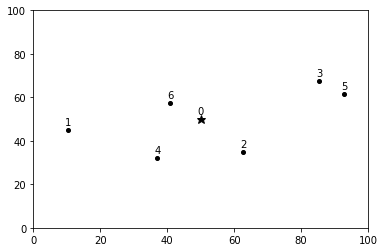

In [47]:
cust_x = field_width*np.random.random(num_cust) # x coordintes of all customers
cust_y = field_height*np.random.random(num_cust) # y coordinates of all customers
cust_dems = list(np.random.randint(dmin,dmax,num_cust)) # Uniformly distributed customer demands
xlocs = list(np.append([depot_x], cust_x)) # depot and customer x-coords
ylocs = list(np.append([depot_y], cust_y)) # depot and customer y-coords
demands = list(np.append([0], cust_dems)) # depot and customer demands
inst = Instance(xlocs, ylocs, demands)
plot_instance(inst, showLabels=True)

### 3) Print instance summary

--- INSTANCE SUMMARY ---
Number of customers: 	 6
Vehicle capacity: 	 8
Primary route size: 	 2
Overlap size: 		 1
Big TSP tour: 		 [6, 1, 4, 2, 5, 3]
Tour demands: 		 [5, 3, 7, 4, 1, 0]
Lowerbound Cost: 	 114

TSP Tour:


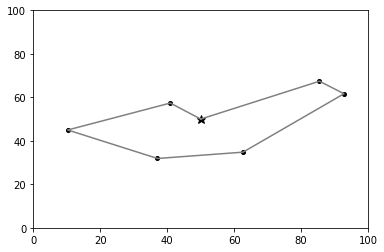

In [48]:
print('--- INSTANCE SUMMARY ---')
print('Number of customers: \t', inst.size)
print('Vehicle capacity: \t', capacity)
print('Primary route size: \t', route_size)
print('Overlap size: \t\t', overlap_size)
print('Big TSP tour: \t\t', inst.tour[1:])
print('Tour demands: \t\t', [inst.demands[c] for c in inst.tour[1:]])
print('Lowerbound Cost: \t', int(inst.get_lowerbound(capacity)))
print()
print('TSP Tour:')
#plot_instance(inst, showTour=True, showLabels=True)
plot_instance(inst, showTour=True)

### 4) Solve routing problem
#### a) Dedicated routing strategy
*The algorithm is described below:*
- Identify a single tour through all *N* customers.
- Split this sequence of *N* customers into into *M* "primary" route segments with equal number of customers ("route_size" or N' customers). This assumes *N* is divisible by *M*.
- Assign a single vehicle (with capacity *Q*) to each route.
- Get information on customers' updated (realized) demands
- Upon learning demands, vehicle *m* executes its primary route *m* in the following manner.
    - The vehicle departs from depot at full capacity.
    - It sequentially visits the customers in its primary route, skipping customers that have 0 demand.
    - Upon exhausting its capacity, the vehicle detours to the depot to refill to full capacity and resumes its route wherever it left off.
    - Upon filling all customer demands in the primary route, the vehicle has completed its route and returns to the depot.


In [49]:
print('--- DEDICATED ROUTING ---')
primary_routes = get_primary_routes(inst, route_size)
segments = create_full_trips(inst,primary_routes,capacity)
combined = np.array([inst.tour[1:], [inst.demands[c] for c in inst.tour[1:]]])
print('\nTour (Row 1), Demand (Row 2):')
print(combined)
print('\nA priori routes:', *primary_routes, sep="\n")
print('\nRealized trips:', *segments, sep="\n")
print('\nTrip count:\t', get_trip_count(segments))
print('Radial cost:\t', np.round(sum([get_radial_cost(inst,seg) for seg in segments]), 1))
print('Circular cost:\t', np.round(sum([get_circular_cost(inst,seg) for seg in segments]), 1))
print('Total cost:\t', np.round(sum([get_total_cost(inst,seg) for seg in segments]), 1))

--- DEDICATED ROUTING ---

Tour (Row 1), Demand (Row 2):
[[6 1 4 2 5 3]
 [5 3 7 4 1 0]]

A priori routes:
[6, 1]
[4, 2]
[5, 3]

Realized trips:
[6, 1]
[4, 2]
[2]
[5]

Trip count:	 4
Radial cost:	 222.0
Circular cost:	 58.7
Total cost:	 280.8


A priori routes (orange) vs. realized  trips (blue)


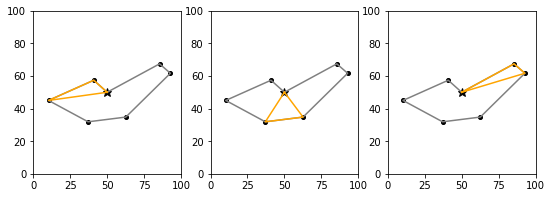

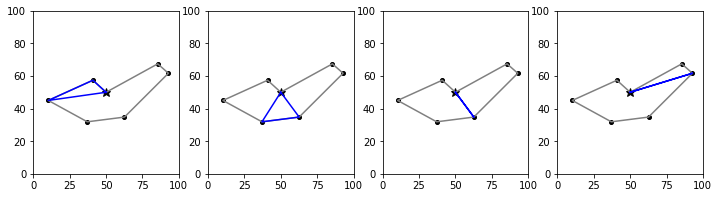

In [50]:
print('A priori routes (orange) vs. realized  trips (blue)')
plot_routes(inst, primary_routes, 'orange', showTour=True)
plot_routes(inst, segments, 'blue', showTour=True)

#### b) Overlapped routing strategy

*The algorithm is described below:*
- Create primary routes as described above in dedicated routing.
- Additionally, create extended routes by assigning each vehicle to all of the customers in its primary route plus some of the customers in a neighboring vehicle's primary route.
    - Extended routes formed under "full adjacent overlapping" means vehicle $m$ is assigned to customers in primary route $m$ plus all customers in primary route $m+1$, for vehicles $m=1,2,...,M-1$.
    - Alternatively, extended routes formed under "partial adjacent overlapping" means vehicle $m$ is assigned to customers in primary route $m$ plus $k$ additional customers in primary route $m+1$, for vehicles $m=1,2,...,M-1$.
    - In both cases, vehicle $m=M$ is assigned to only its primary route.
- Upon learning customer demands, vehicle *m* executes its extended route in the following manner.
    - The vehicle departs from depot at full capacity.
    - It sequentially visits the customers in its primary route, skipping customers that have 0 demand or demand that has already been filled. The vehicle reloads at the depot as needed.
    - Upon filling demand of the final customer in the primary route, the vehicle either (a) permanently returns to the depot if no capacity remains or (b) proceeds with the customers in the extended route and fills those customer demands until the leftover vehicle capacity is exhausted, at which point the vehicle permanently returns to the depot.
    - Vehicle *m+1* then starts primary route *m+1* wherever  vehicle *m* left off.
    - However, in the case that vehicle *m-1* satisfied the demand of ALL customers in the extended route (meaning it covered all demand in vehicle *m*'s primary route), then vehicle *m* is never deployed. Instead vehicle *m+1* just starts its route at the beginning of primary route *m+1*.

Note that a central planner assesses the realized customer demands and coordinate each vehicle's starting and ending customers (realized routes) within the extended route prior to the vehicle's departing the depot.

In [51]:
print('--- OVERLAPPED ROUTING ---')
primary_routes = get_primary_routes(inst, route_size)
extended_routes = get_extended_routes(inst, route_size, overlap_size)
segments = implement_k_overlapped_alg(inst,primary_routes,extended_routes,capacity,route_size,overlap_size)
combined = np.array([inst.tour[1:], [inst.demands[c] for c in inst.tour[1:]]])
print('\nTour (Row 1), Demand (Row 2):')
print(combined)
print('\nA priori routes:', *extended_routes, sep="\n")
print('\nRealized trips:', *segments, sep="\n")
print('\nTrip count:\t', get_trip_count(segments))
print('Radial cost:\t', np.round(sum([get_radial_cost(inst,seg) for seg in segments]), 1))
print('Circular cost:\t', np.round(sum([get_circular_cost(inst,seg) for seg in segments]), 1))
print('Total cost:\t', np.round(sum([get_total_cost(inst,seg) for seg in segments]), 1))

--- OVERLAPPED ROUTING ---

Tour (Row 1), Demand (Row 2):
[[6 1 4 2 5 3]
 [5 3 7 4 1 0]]

A priori routes:
[6, 1, 4]
[4, 2, 5]
[5, 3]

Realized trips:
[6, 1]
[4, 2]
[2, 5]
[]

Trip count:	 3
Radial cost:	 157.9
Circular cost:	 99.1
Total cost:	 257.0


A priori routes (orange) vs. realized  trips (blue)


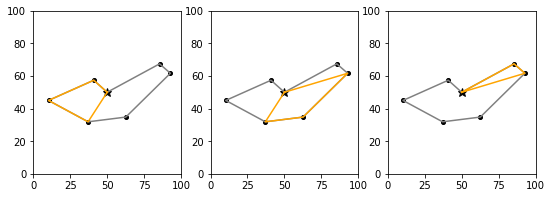

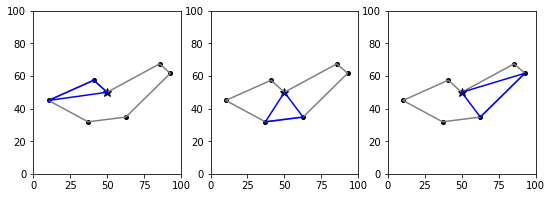

In [52]:
print('A priori routes (orange) vs. realized  trips (blue)')
plot_routes(inst, extended_routes, 'orange', showTour=True)
plot_routes(inst, segments, 'blue', showTour=True)

#### c) Fully flexible routing strategy

*The algorithm is described below:*
- As in the dedicated and overlapped routing strategies, create a large tour through all customers.
- Select a starting customer and send out a vehicle at full capacity to sequentially fill as much customer demand as possible.
- The vehicle returns to the depot upon exhuasting its capacity, and the next vehicle continues with the customer sequence where the previous vehicle left off.


Note that as in the overlapped routing strategies, demands are learned in advance, which means each truck's starting and ending customers can be determined prior to the day's deliveries so that vehicles can execute their realized routes simultaneously.

Also note that this strategy differs from full reoptimization since the sequence of customer visits within individul trips is fixed. In reoptimization, on the other hand, an individual vehicle trip can consists of any of the *N* customers.

--- FULLY FLEXIBLE ROUTING ---

Tour (Row 1), Demand (Row 2):
[[6 1 4 2 5 3]
 [5 3 7 4 1 0]]

Realized trips:
[6, 1]
[4, 2]
[2, 5]

Trip count:	 3
Radial cost:	 157.9
Circular cost:	 99.1
Total cost:	 257.0

Realized trips:


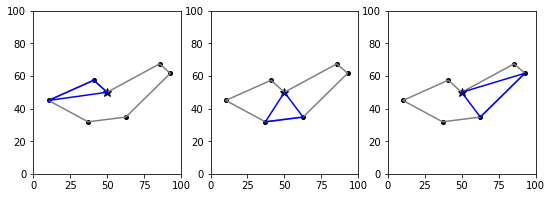

In [53]:
print('--- FULLY FLEXIBLE ROUTING ---')
segments = create_full_trips(inst,[inst.tour[1:]],capacity)
combined = np.array([inst.tour[1:], [inst.demands[c] for c in inst.tour[1:]]])
print('\nTour (Row 1), Demand (Row 2):')
print(combined)
print('\nRealized trips:', *segments, sep="\n")
print('\nTrip count:\t', get_trip_count(segments))
print('Radial cost:\t', np.round(sum([get_radial_cost(inst,seg) for seg in segments]), 1))
print('Circular cost:\t', np.round(sum([get_circular_cost(inst,seg) for seg in segments]), 1))
print('Total cost:\t', np.round(sum([get_total_cost(inst,seg) for seg in segments]), 1))
print()
print('Realized trips:')
plot_routes(inst, segments, 'blue', showTour=True)

#### d) Reoptimization

--- REOPTIMIZATION (SDVRP) ---

Tour (Row 1), Demand (Row 2):
[[6 1 4 2 5 3]
 [5 3 7 4 1 0]]

Trip count:	 3
Radial cost:	 160.4
Circular cost:	 73.4
Total cost:	 233.8

Realized trips:


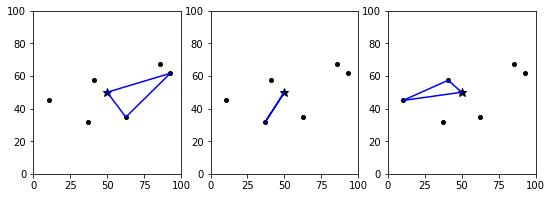

In [54]:
print('--- REOPTIMIZATION (SDVRP) ---')
combined = np.array([inst.tour[1:], [inst.demands[c] for c in inst.tour[1:]]])
print('\nTour (Row 1), Demand (Row 2):')
print(combined)
segments = solve_SDVRP(inst, capacity)
print('\nTrip count:\t', get_trip_count(segments))
print('Radial cost:\t', np.round(sum([get_radial_cost(inst,seg) for seg in segments]), 1))
print('Circular cost:\t', np.round(sum([get_circular_cost(inst,seg) for seg in segments]), 1))
print('Total cost:\t', np.round(sum([get_total_cost(inst,seg) for seg in segments]), 1))
print()
print('Realized trips:')
plot_routes(inst, segments, 'blue')

#### e) Simulation Setup: Rotating Routes

This last part illustrates the route selection process in the simulation code, in which we want to estimate the expected cost over various customer locations and demands. The steps are outlined below.

At the beginning of the simulation of a given problem size...

1. Generate several location customer instances, each with several demand instances.
2. **For each customer instance,** create extended routes starting with the first customer in the TSP tour.
3. Find the average overlapped routing cost over all demand instances using this set of extended routes.
4. Rotate through all the customers, and repeat steps 2 and 3 using a new set of routes with each new starting customer.
5. Keep the starting customer and set of routes that yields the lowest average cost under overlapped routing. Update the TSP tour to begin with this starting customer. As a result, the dedicated, overlapped, and fully flexible strategies will be simulated using routes generated from this starting customer for all demand instances.
6. Repeat the route rotation process in steps 2-5 for each independent set of customer locations.

After setting the lowest cost tour for all customers, proceed to simulate all strategies to find their routing costs.

**Important:** Demand instances are created according to the scenario. Below we specify a "baseline" scenario in which each customer's demand is uniformly drawn from 0,1,2,...,8.

In [99]:
def create_instances(scenario, num_cust, cust_sims, dem_sims):
    """Returns cust_sims by dem_sims array of Instances"""

    np.random.seed(1)

    def gen_new_instance(num_cust, scenario):

        # Generate customer locations
        new_xlocs = field_width * np.random.random(num_cust)  # x coordinates of all customers
        new_ylocs = field_height * np.random.random(num_cust)  # y coordinates of all customers

        # Generate demands depending on scenario
        if scenario in ['baseline']:
            new_dems = list(np.random.randint(0, 8, num_cust))  # Uniformly distributed between 0 and 8
        else:
            raise ValueError('Scenario is undefined. Use \"baseline\" or define a new scenario in the gen_new_instance function.')
            
        # Return new instance
        new_xlocs = list(np.append([depot_x], new_xlocs))  # include depot in customer x-coords
        new_ylocs = list(np.append([depot_y], new_ylocs))  # include depot in customer y-coords
        new_dems = list(np.append([0], new_dems))  # include depot in customer demands
        return Instance(new_xlocs, new_ylocs, new_dems)

    def update_demands(inst, scenario):
        # Creates copy of instance with updated demands depending on scenario
        if scenario in ['baseline']:
            new_dems = list(np.random.randint(0, 8, num_cust))  # Uniformly distributed between 0 and 8
        else:
            raise ValueError('Scenario is undefined. Use \"baseline\" or define a new scenario in the update_demands function.')
            
        new_dems = list(np.append([0], new_dems))  # include depot in customer demands
        new_inst = Instance(inst.xlocs, inst.ylocs, new_dems, solve_TSP=False)
        new_inst.tour = inst.tour
        return new_inst

    # Create instance array with new customer instances
    instances = [[None for j in range(dem_sims)] for i in range(cust_sims)]
    customer_instances = [gen_new_instance(num_cust, scenario) for i in range(cust_sims)]

    # Create demand instances for each customer instance
    for i in range(cust_sims):
        for j in range(dem_sims):
            instances[i][j] = update_demands(customer_instances[i], scenario)

    return instances


def set_best_tours(demand_instances, primary_routes, extended_routes, capacity, route_size, overlap_size):
    """Updates the tour of all instances to the sequence that minimizes the average cost of the routes over all demand instances.
    Assumes all instances in list demand_instances have identical customer locations."""

    # Get any customer instance
    inst = demand_instances[0]
    # Set current tour and cumulative cost over all demand instances as best so far
    # Note: cumulative cost yields same tour ranking as average cost across demand instances
    best_tour = inst.tour
    segments = implement_k_overlapped_alg(inst, primary_routes, extended_routes, capacity, route_size, overlap_size)
    lowest_cumul_cost = sum([get_total_cost(inst, seg) for seg in segments for inst in demand_instances])
    print('Initial Tour: {}, Cost: {}'.format(best_tour, lowest_cumul_cost.round(2)))

    # Copy of tour (for rotating below)
    tour = inst.tour

    # Loop over all customers
    for c in range(inst.size):

        # Rotate tour by one customer (keeps depot at very first spot)
        tour = tour[0:1] + tour[2:] + tour[1:2]
        inst.update_tour(tour)
        tour_cost = 0
        
        # Get cumulative cost over all demand instances
        for inst in demand_instances:
            segments = implement_k_overlapped_alg(inst, primary_routes, extended_routes, capacity, route_size,
                                                  overlap_size)
            for seg in segments:
                tour_cost += get_total_cost(inst, seg)
        print('Candidate Tour: {}, Cost: {}'.format(tour, tour_cost.round(2)))
        if tour_cost < lowest_cumul_cost:
            # Set as new best tour and cost
            best_tour = tour
            lowest_cumul_cost = tour_cost
            print('--> NEW BEST TOUR: {}, COST: {}'.format(best_tour, lowest_cumul_cost.round(2)))
    # Update tour for all demand instances in this customer row
    for inst in demand_instances:
        inst.update_tour(best_tour)
    return


def example_setup(scenario, num_cust, capacity, route_size, overlap_size, cust_sims, dem_sims):

    # Create all customer and demand instances for this problem size
    print('Creating customer instances')
    instances = create_instances(scenario, num_cust, cust_sims, dem_sims)

    # Find cost minimizing starting customer / tour sequence for each set of customer locations
    print('Finding best tours across demand sets')
    for r in range(len(instances)):
        print('\nStarting customer instance {}'.format(r+1))
        row = instances[r]
        inst = row[0]  # customer instance
        primary_routes = get_primary_routes(inst, route_size)
        extended_routes = get_extended_routes(inst, route_size, overlap_size)
        set_best_tours(row, primary_routes, extended_routes, capacity, route_size,
                       overlap_size)  # set cost-minimizing sequence

    print('\nSimulation setup complete.')

In [102]:
example_setup(scenario = 'baseline',
              num_cust = inst.size,
              capacity = capacity,
              route_size = route_size,
              overlap_size = overlap_size,
              cust_sims = 2,
              dem_sims = 10)

Creating customer instances
Finding best tours across demand sets

Starting customer instance 1
Initial Tour: [0, 4, 6, 3, 5, 1, 2], Cost: 4085.11
Candidate Tour: [0, 6, 3, 5, 1, 2, 4], Cost: 3263.17
--> NEW BEST TOUR: [0, 6, 3, 5, 1, 2, 4], COST: 3263.17
Candidate Tour: [0, 3, 5, 1, 2, 4, 6], Cost: 3158.59
--> NEW BEST TOUR: [0, 3, 5, 1, 2, 4, 6], COST: 3158.59
Candidate Tour: [0, 5, 1, 2, 4, 6, 3], Cost: 3263.17
Candidate Tour: [0, 1, 2, 4, 6, 3, 5], Cost: 3158.8
Candidate Tour: [0, 2, 4, 6, 3, 5, 1], Cost: 3234.46
Candidate Tour: [0, 4, 6, 3, 5, 1, 2], Cost: 3263.17

Starting customer instance 2
Initial Tour: [0, 3, 1, 5, 4, 2, 6], Cost: 3488.37
Candidate Tour: [0, 1, 5, 4, 2, 6, 3], Cost: 3783.53
Candidate Tour: [0, 5, 4, 2, 6, 3, 1], Cost: 3636.15
Candidate Tour: [0, 4, 2, 6, 3, 1, 5], Cost: 3783.53
Candidate Tour: [0, 2, 6, 3, 1, 5, 4], Cost: 3679.41
Candidate Tour: [0, 6, 3, 1, 5, 4, 2], Cost: 3681.03
Candidate Tour: [0, 3, 1, 5, 4, 2, 6], Cost: 3783.53

Simulation setup complet